In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import scipy.optimize as opt

In [18]:
def sinc(x,y,sigma=1):
    return np.exp(-(x**2+y**2)/(2*sigma**2))*(np.cos(2*np.pi*x*y))

def sinc_eggshell(x,y,sigma=1):
    return ((x**2 + y**2 + 25 * (np.sin(2*np.pi*x)**2 + np.sin(2*np.pi*y)**2))**0.5)  *  np.exp(-(x**2+y**2)/(2*sigma**2))

pi = np.pi
cos = np.cos
def Brannin(x,y):
    a = 1 
    b = 5.1/(4*pi**2)
    c = 5/pi
    r = 6
    s = 10
    t = 1/(8*pi)
    return a*(y-b * x**2 + c*x - r)**2 + s*(1-t)*cos(x) + s

In [3]:
def pred_ints(model,X_list,mdtype):
    if(mdtype=="RF"):
        est_num = len(model.estimators_)
        preds = np.zeros((est_num,len(X_list)))
        for i,pred in enumerate(model.estimators_):
            preds[i] = pred.predict(X_list)

        means = np.mean(preds,axis=0)
        std = np.std(preds,axis=0)
    elif(mdtype=="GP"):
        means,std = model.predict(X_list,return_std=True)
    return means, std

def gamma(x_list,model,fstar,epsilon=0.01):
    return model.predict(x_list)-fstar+epsilon

def z(x_list,model,fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    return gamma(x_list,model,fstar)/sigma

def EI(x_list,model, fstar,mdl='GP'):
    mu, sigma = pred_ints(model,x_list,mdtype=mdl)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis

def EI_single(x, model, fstar, mdl='GP'):
    mu, sigma = pred_ints(model,[x],mdtype=mdl)
    zl = z([x],model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma([x],model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis

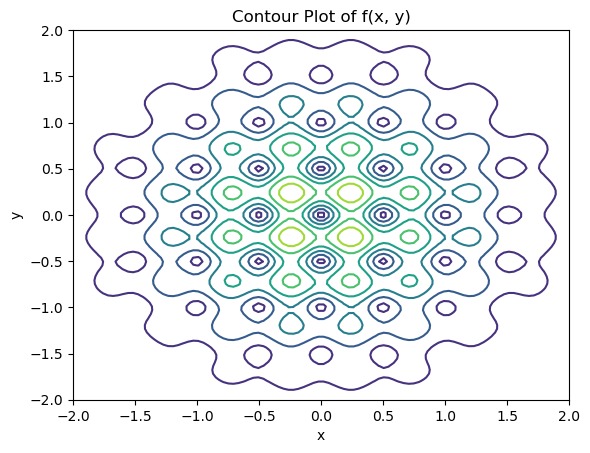

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to plot
def f(x, y):
    return x**2 + y**2



# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, Z)

# Add labels and a title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Surface Plot of f(x, y)')

# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of f(x, y)')

# Show the plot
plt.show()


In [152]:
# surrogate
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(5e-1,1e2))
gpr = GaussianProcessRegressor()

In [153]:
x_init = np.random.random((5,2))*4-2
y_init = [sinc_eggshell(*x_) for x_ in x_init]
gpr.fit(x_init,y_init)
ymaxs = []
xadded = []
xmaxs = []
candidates = np.random.random((1500,2))*4-2
HO_x = candidates[:100]
HO_y = sinc(HO_x[:,0],HO_x[:,1])

In [157]:
for x in range(25):
    #yei = EI(candidates,gpr,np.max(y_init))
    #x0 = candidates[np.argmax(yei)]
    f = lambda x: -1*EI_single(x,gpr,max(y_init))
    xx = opt.minimize(f,x0=x_init[np.argmax(y_init)],method='Nelder-Mead')
    print(xx.message,f(xx.x),mean_squared_error(HO_y,gpr.predict(HO_x)))
    x_init = np.append(x_init,[xx.x],axis=0)
    y_init = np.append(y_init,[sinc_eggshell(*xx.x)],axis=0)
    xadded.append(xx.x)
    print(len(x_init),len(y_init))
    gpr.fit(x_init,y_init)
    ymaxs.append(max(y_init))
    xmaxs.append(x_init[np.argmax(y_init)])

Optimization terminated successfully. [-0.00799318] 14532.576827690444
31 31
Optimization terminated successfully. [-0.0080097] 14547.592911918804
32 32
Optimization terminated successfully. [-0.00801954] 14556.299621104044
33 33
Optimization terminated successfully. [-0.00802782] 14563.653240684229
34 34
Optimization terminated successfully. [-0.00803484] 14569.913464310765
35 35
Optimization terminated successfully. [-0.00804098] 14575.320271601495
36 36
Optimization terminated successfully. [-0.00804956] 14583.141917180494
37 37
Optimization terminated successfully. [-0.00805721] 14590.024963696747
38 38
Optimization terminated successfully. [-0.00806388] 14596.129357768234
39 39
Optimization terminated successfully. [-0.00806985] 14601.580153942175
40 40
Optimization terminated successfully. [-0.00806722] 14599.164063620781
41 41
Optimization terminated successfully. [-0.0080649] 14596.98445092195
42 42
Optimization terminated successfully. [-0.00806761] 14599.38474560535
43 43
Opt

Text(0, 0.5, 'Value of maximum in data set')

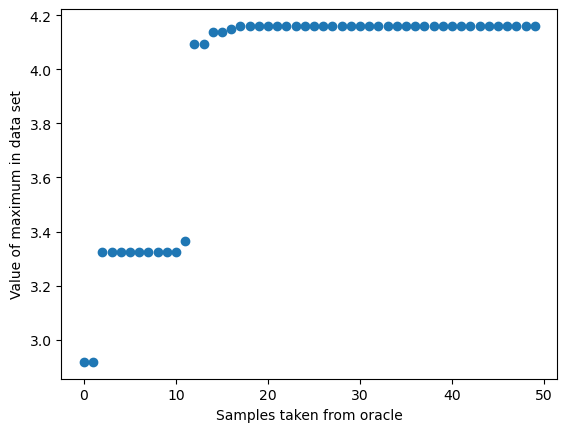

In [158]:
plt.plot(ymaxs,'o')
plt.xlabel('Samples taken from oracle')
plt.ylabel('Value of maximum in data set')

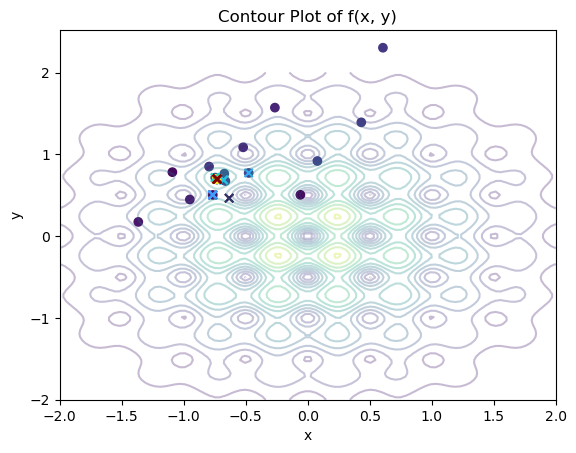

In [159]:
# Create a 3D plot of the function
fig = plt.figure()
ax = fig.add_subplot(111)
# Generate x and y values for the function
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

# Compute the function values for the grid
Z = sinc_eggshell(X, Y)

ax.contour(X, Y, Z,levels=10,alpha=0.3)
ax.scatter(np.array(xadded)[:,0],np.array(xadded)[:,1],c=range(len(xadded)))
ax.scatter(np.array(xmaxs)[:,0],np.array(xmaxs)[:,1],c=range(len(xmaxs)),cmap='turbo',marker='x')


# Add labels and a title
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Surface Plot of f(x, y)')

# Add labels and a title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of f(x, y)')
#plt.ylim(-2,2)
#plt.xlim(-2,2)
# Show the plot
plt.show()

